In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

# Acc and ECE

In [19]:
datasets = ["bloodmnist", "dermamnist", "pneumoniamnist", "organsmnist", "organcmnist"]

columns = [
    "dataset",
    "seed",
    "experiment_type",
    "num_labeled",
    "test_acc",
    "test_loss",
    "test_ece",
    "acc_per_class",
    "class_dist",
    "full_dist",
    "optim",
]
df = pd.DataFrame(columns=columns)


for dataset in datasets:
    test_dirs = [f"./runs/{dataset}/test", f"./test/{dataset}"]

    for test_dir in test_dirs:
        if not os.path.exists(test_dir):
            continue

        for seed in os.listdir(test_dir):
            for folder in os.listdir(f"{test_dir}/{seed}"):
                exp_type, calibrated, optim, num_labeled = folder.split("_")
                exp_type = f"{exp_type}_{calibrated}"

                test_metrics = pd.read_csv(f"{test_dir}/{seed}/{folder}/test_metrics.csv")
                acc_per_class = pd.read_csv(f"{test_dir}/{seed}/{folder}/accuracy_per_class.csv")
                class_dist = pd.read_csv(f"{test_dir}/{seed}/{folder}/class_distribution.csv")
                full_dist = pd.read_csv(f"{test_dir}/{seed}/{folder}/full_distribution.csv")

                acc_per_class_dict = {}
                class_dist_dict = {}
                full_dist_dict = {}

                for acc_col, dist_col, full_col in zip(acc_per_class.columns, class_dist.columns, full_dist.columns):
                    acc_per_class_dict[acc_col] = acc_per_class[acc_col].values[0]
                    class_dist_dict[dist_col] = class_dist[dist_col].values[0]
                    full_dist_dict[full_col] = full_dist[full_col].values[0]

                test_acc = test_metrics["test_acc"].values[-1]
                test_loss = test_metrics["test_loss"].values[-1]
                test_ece = test_metrics["test_ece"].values[-1]

                df.loc[len(df)] = {
                    "dataset": dataset,
                    "seed": int(seed.split("_")[-1]),
                    "experiment_type": exp_type,
                    "num_labeled": int(num_labeled),
                    "test_acc": test_acc,
                    "test_loss": test_loss,
                    "test_ece": test_ece,
                    "acc_per_class": acc_per_class_dict,
                    "class_dist": class_dist_dict,
                    "full_dist": full_dist_dict,
                    "optim": optim,
                }

df = df.sort_values(by=["experiment_type", "num_labeled"])

In [20]:
df_agg = df.groupby(["dataset", "experiment_type", "num_labeled", "optim"]).agg(
    {
        "test_acc": ["mean", "std"],
        "test_loss": ["mean", "std"],
        "test_ece": ["mean", "std"],
    }
)

df_agg

test_acc            \
                                                      mean       std   
dataset        experiment_type num_labeled optim                       
bloodmnist     active_jempp    250         sgd    0.825490  0.000000   
                               500         sgd    0.892137  0.000000   
                               750         sgd    0.923999  0.000000   
                               1000        sgd    0.924525  0.000131   
                               1250        sgd    0.937153  0.000000   
...                                                    ...       ...   
pneumoniamnist equal_jempp     1600        adam   0.908654  0.000000   
                               1800        adam   0.892628  0.000000   
                               2000        adam   0.905449  0.000000   
                               2200        adam   0.903846  0.000000   
                               2400        adam   0.907051  0.000000   

                                                 test_loss                \
                                                      mean           std   
dataset        experiment_type num_labeled optim                           
bloodmnist     active_jempp    250         sgd    0.898172  2.427320e-05   
                               500         sgd    0.365081  9.783468e-06   
                               750         sgd    0.288294  4.810347e-06   
                               1000        sgd    0.276163  1.086031e-05   
                               1250        sgd    0.204140  5.725859e-07   
...                                                    ...           ...   
pneumoniamnist equal_jempp     1600        adam   0.712704  0.000000e+00   
                               1800        adam   0.760778  0.000000e+00   
                               2000        adam   0.734278  0.000000e+00   
                               2200        adam   0.759218  0.000000e+00   
                               2400        adam   0.661781  0.000000e+00   

                                                  test_ece                
                                                      mean           std  
dataset        experiment_type num_labeled optim                          
bloodmnist     active_jempp    250         sgd    0.120292  1.970063e-06  
                               500         sgd    0.050734  2.862774e-07  
                               750         sgd    0.042941  1.096040e-06  
                               1000        sgd    0.040528  1.314203e-04  
                               1250        sgd    0.024737  2.424208e-07  
...                                                    ...           ...  
pneumoniamnist equal_jempp     1600        adam   0.085442  0.000000e+00  
                               1800        adam   0.099364  0.000000e+00  
                               2000        adam   0.091881  0.000000e+00  
                               2200        adam   0.089902  0.000000e+00  
                               2400        adam   0.084571  0.000000e+00  

[195 rows x 6 columns]

In [21]:
results = df_agg.xs("organcmnist", level="dataset")
# get test ece of actvive_softmax
active_softmax = results.xs("baseline_softmax", level="experiment_type")
active_softmax["test_ece"]

,,mean,std
num_labeled,optim,,
4000,sgd,0.053127,0.0


In [22]:
# Reset the index of the results DataFrame
# Get the index of the minimum test_ece for each experiment type
min_ece_idx = results.groupby(["experiment_type", "optim"])["test_ece"].idxmin()
min_ece_idx

test_ece  \
                                                 mean   
experiment_type  optim                                  
active_jempp     sgd        (active_jempp, 4000, sgd)   
active_softmax   sgd       (active_softmax, 250, sgd)   
baseline_softmax sgd    (baseline_softmax, 4000, sgd)   

                                                       
                                                  std  
experiment_type  optim                                 
active_jempp     sgd         (active_jempp, 250, sgd)  
active_softmax   sgd       (active_softmax, 250, sgd)  
baseline_softmax sgd    (baseline_softmax, 4000, sgd)

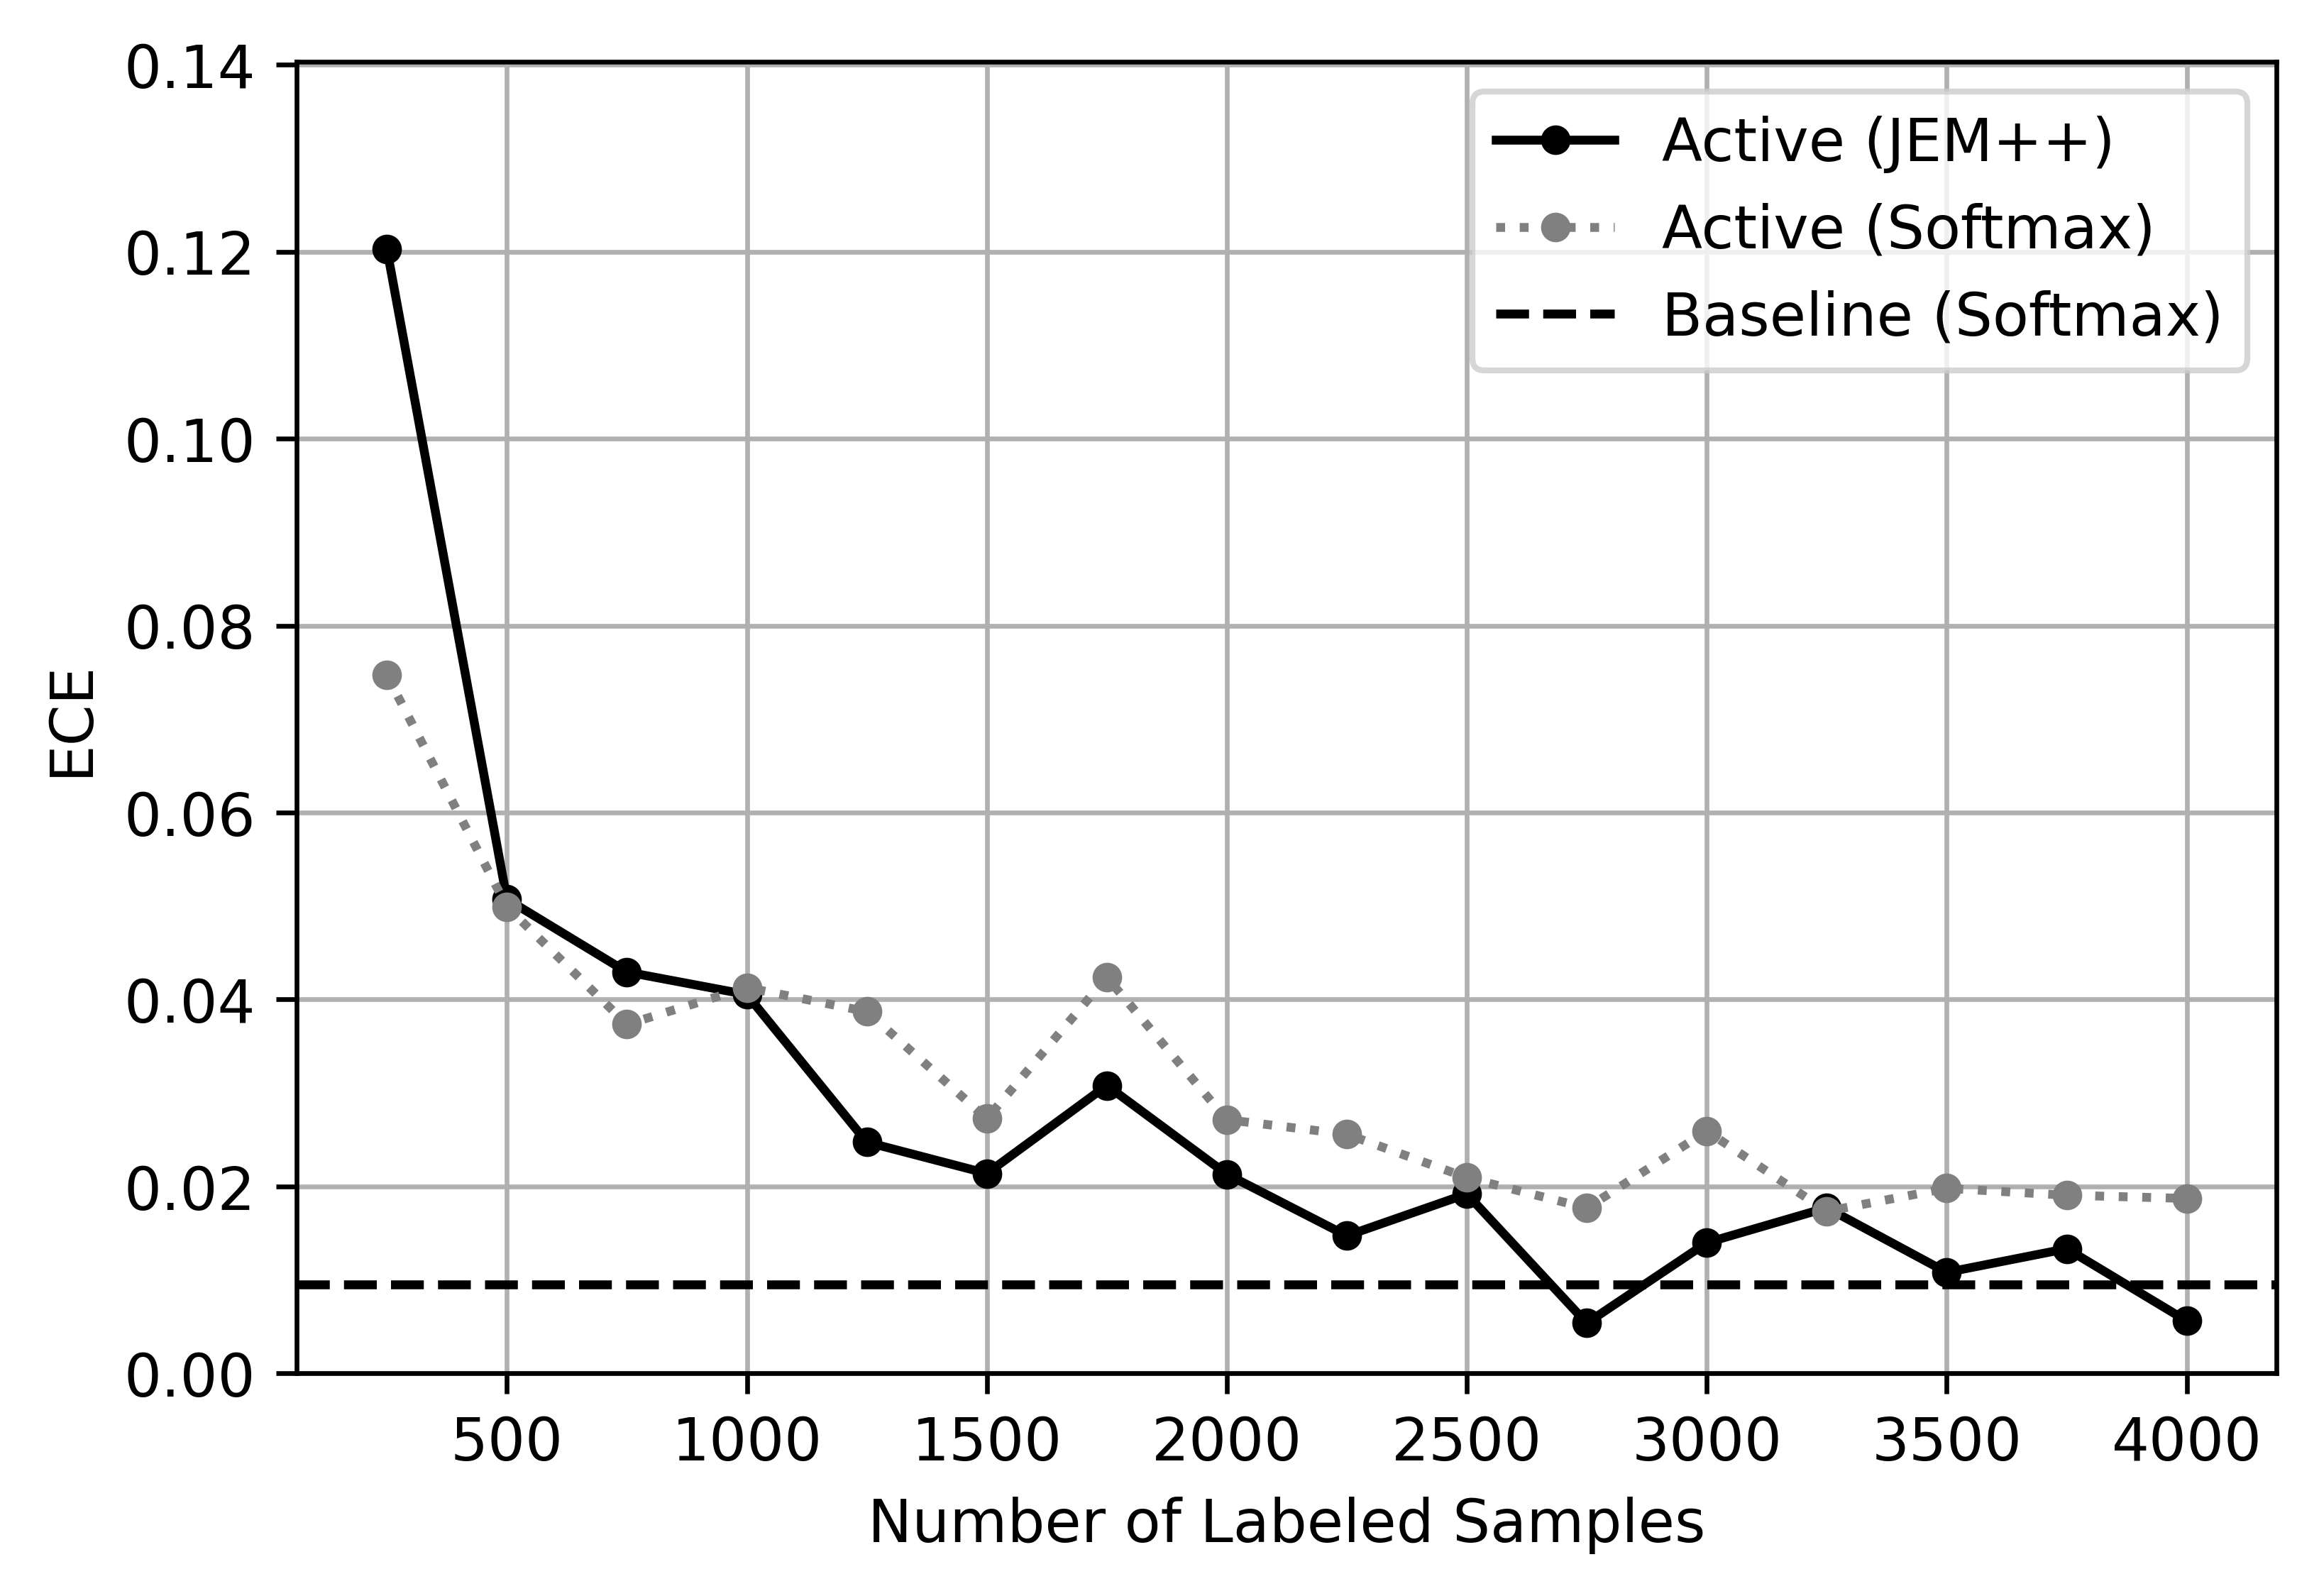

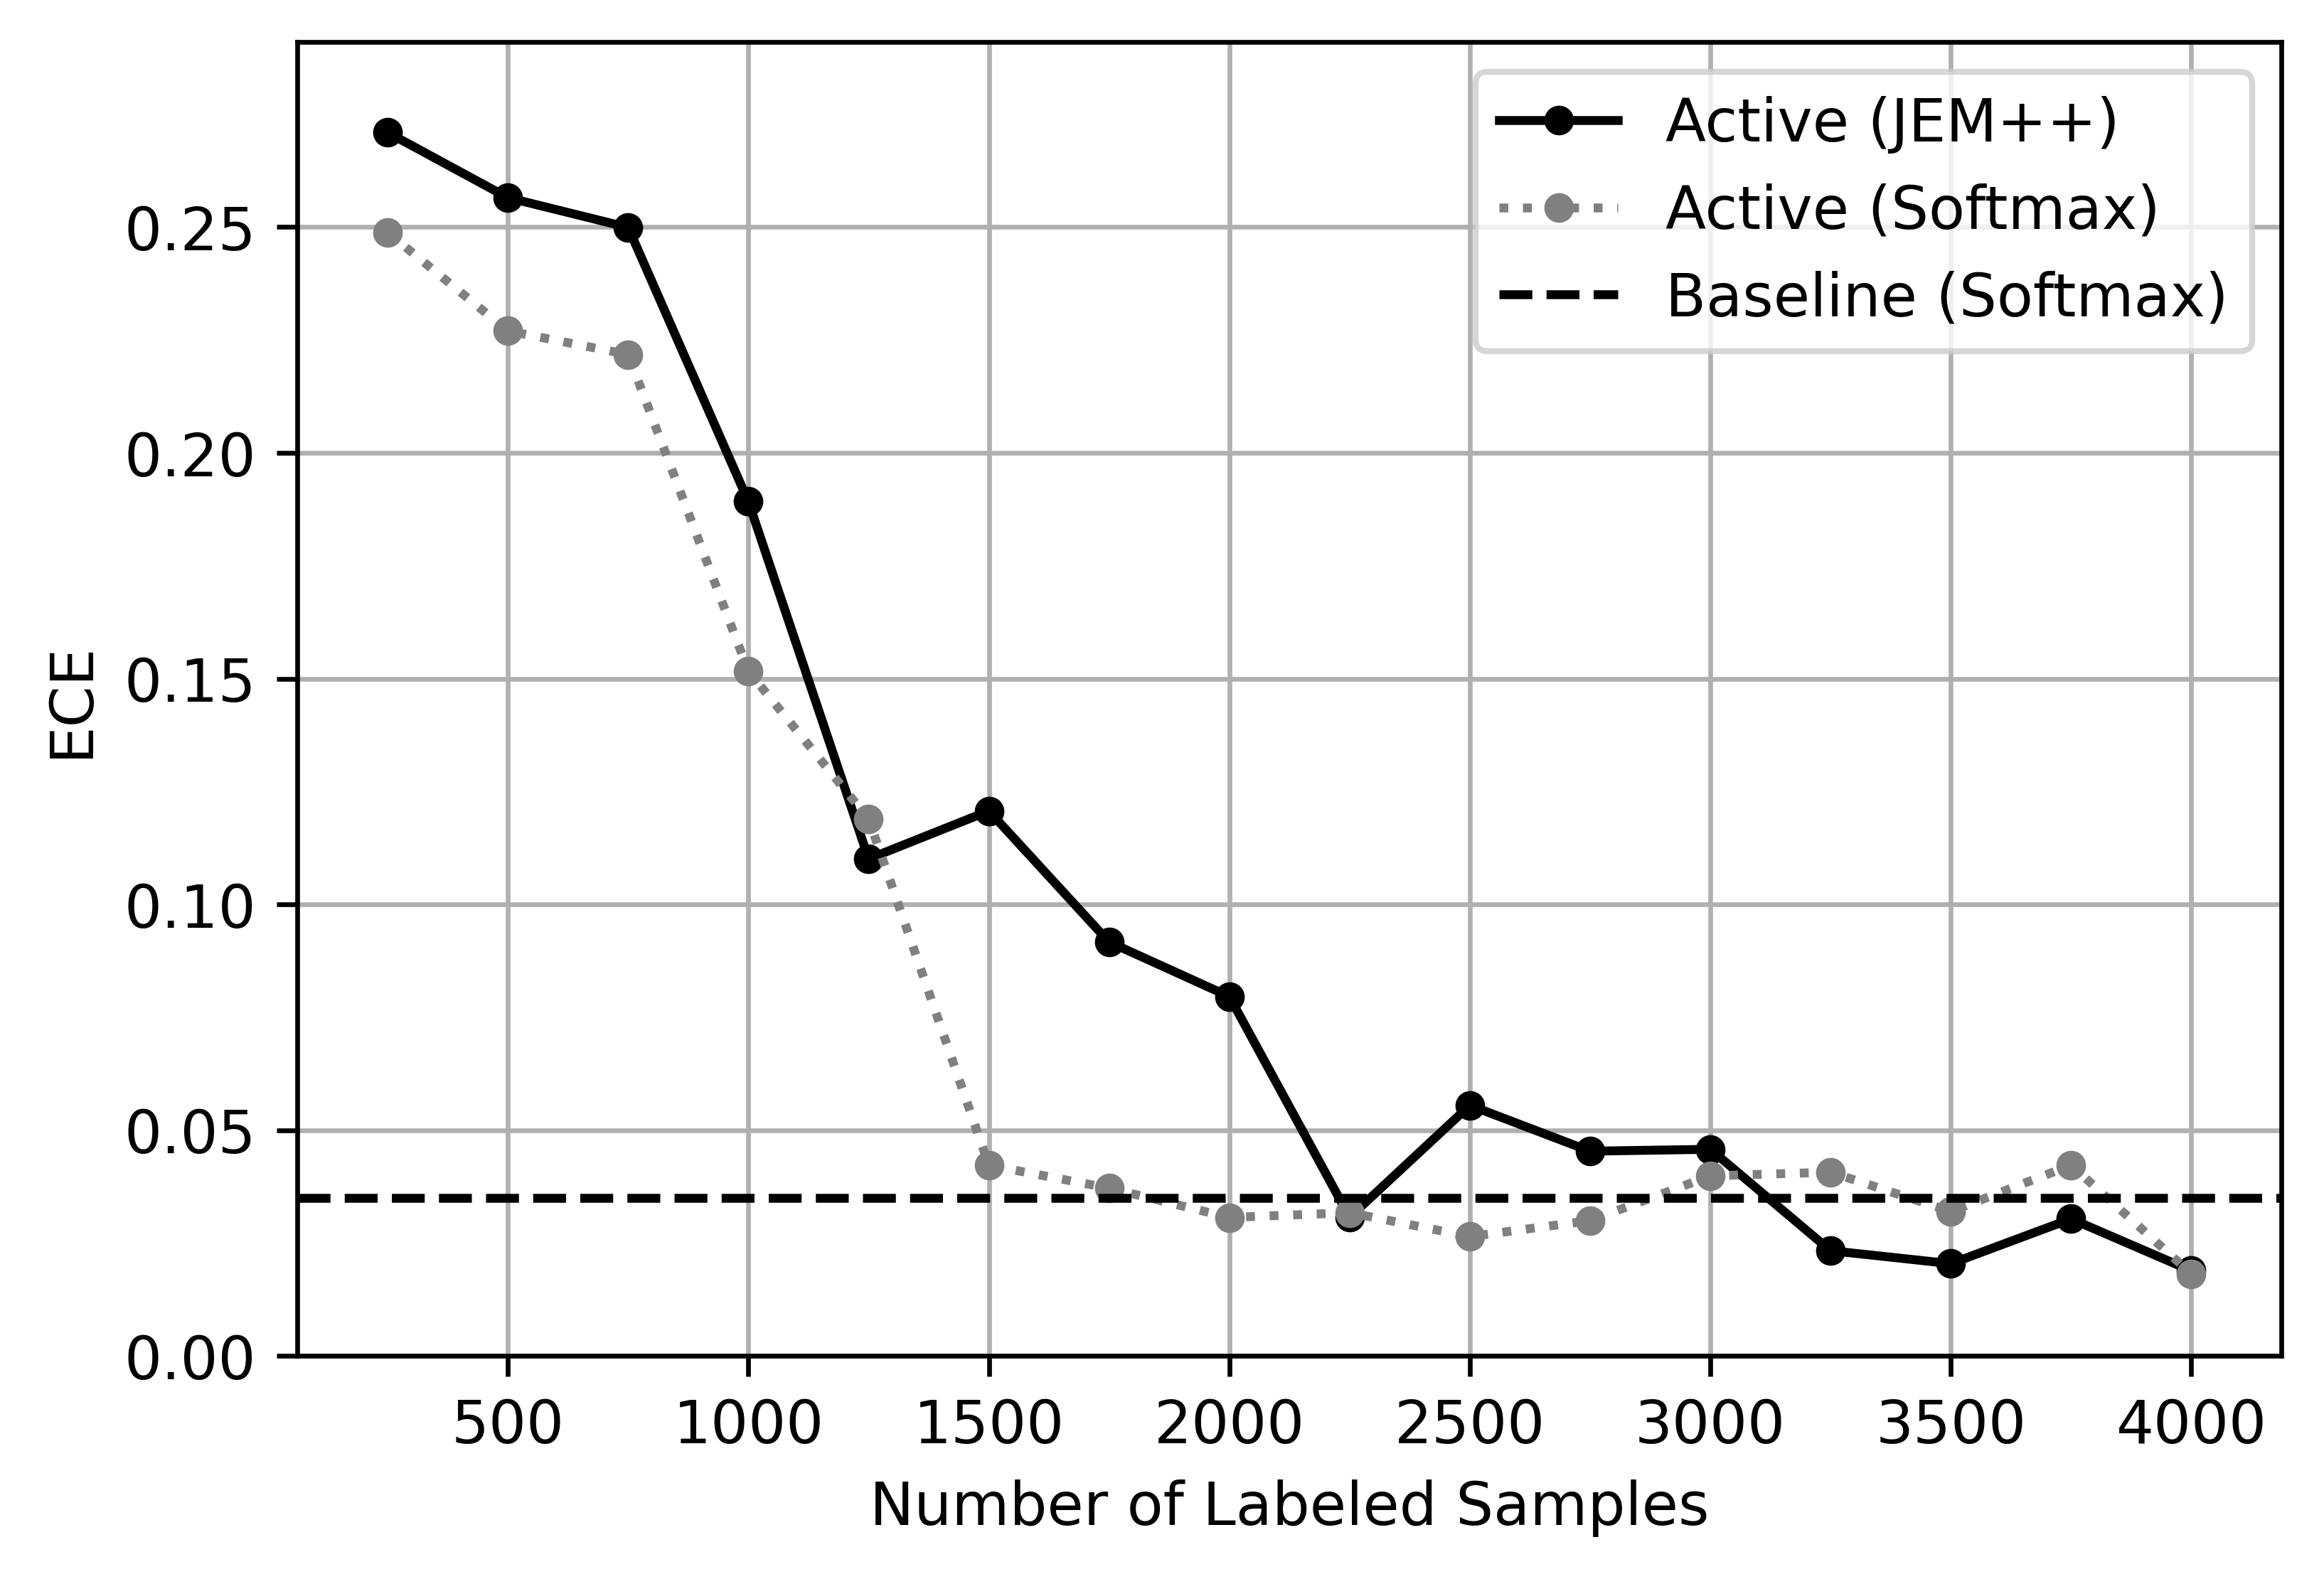

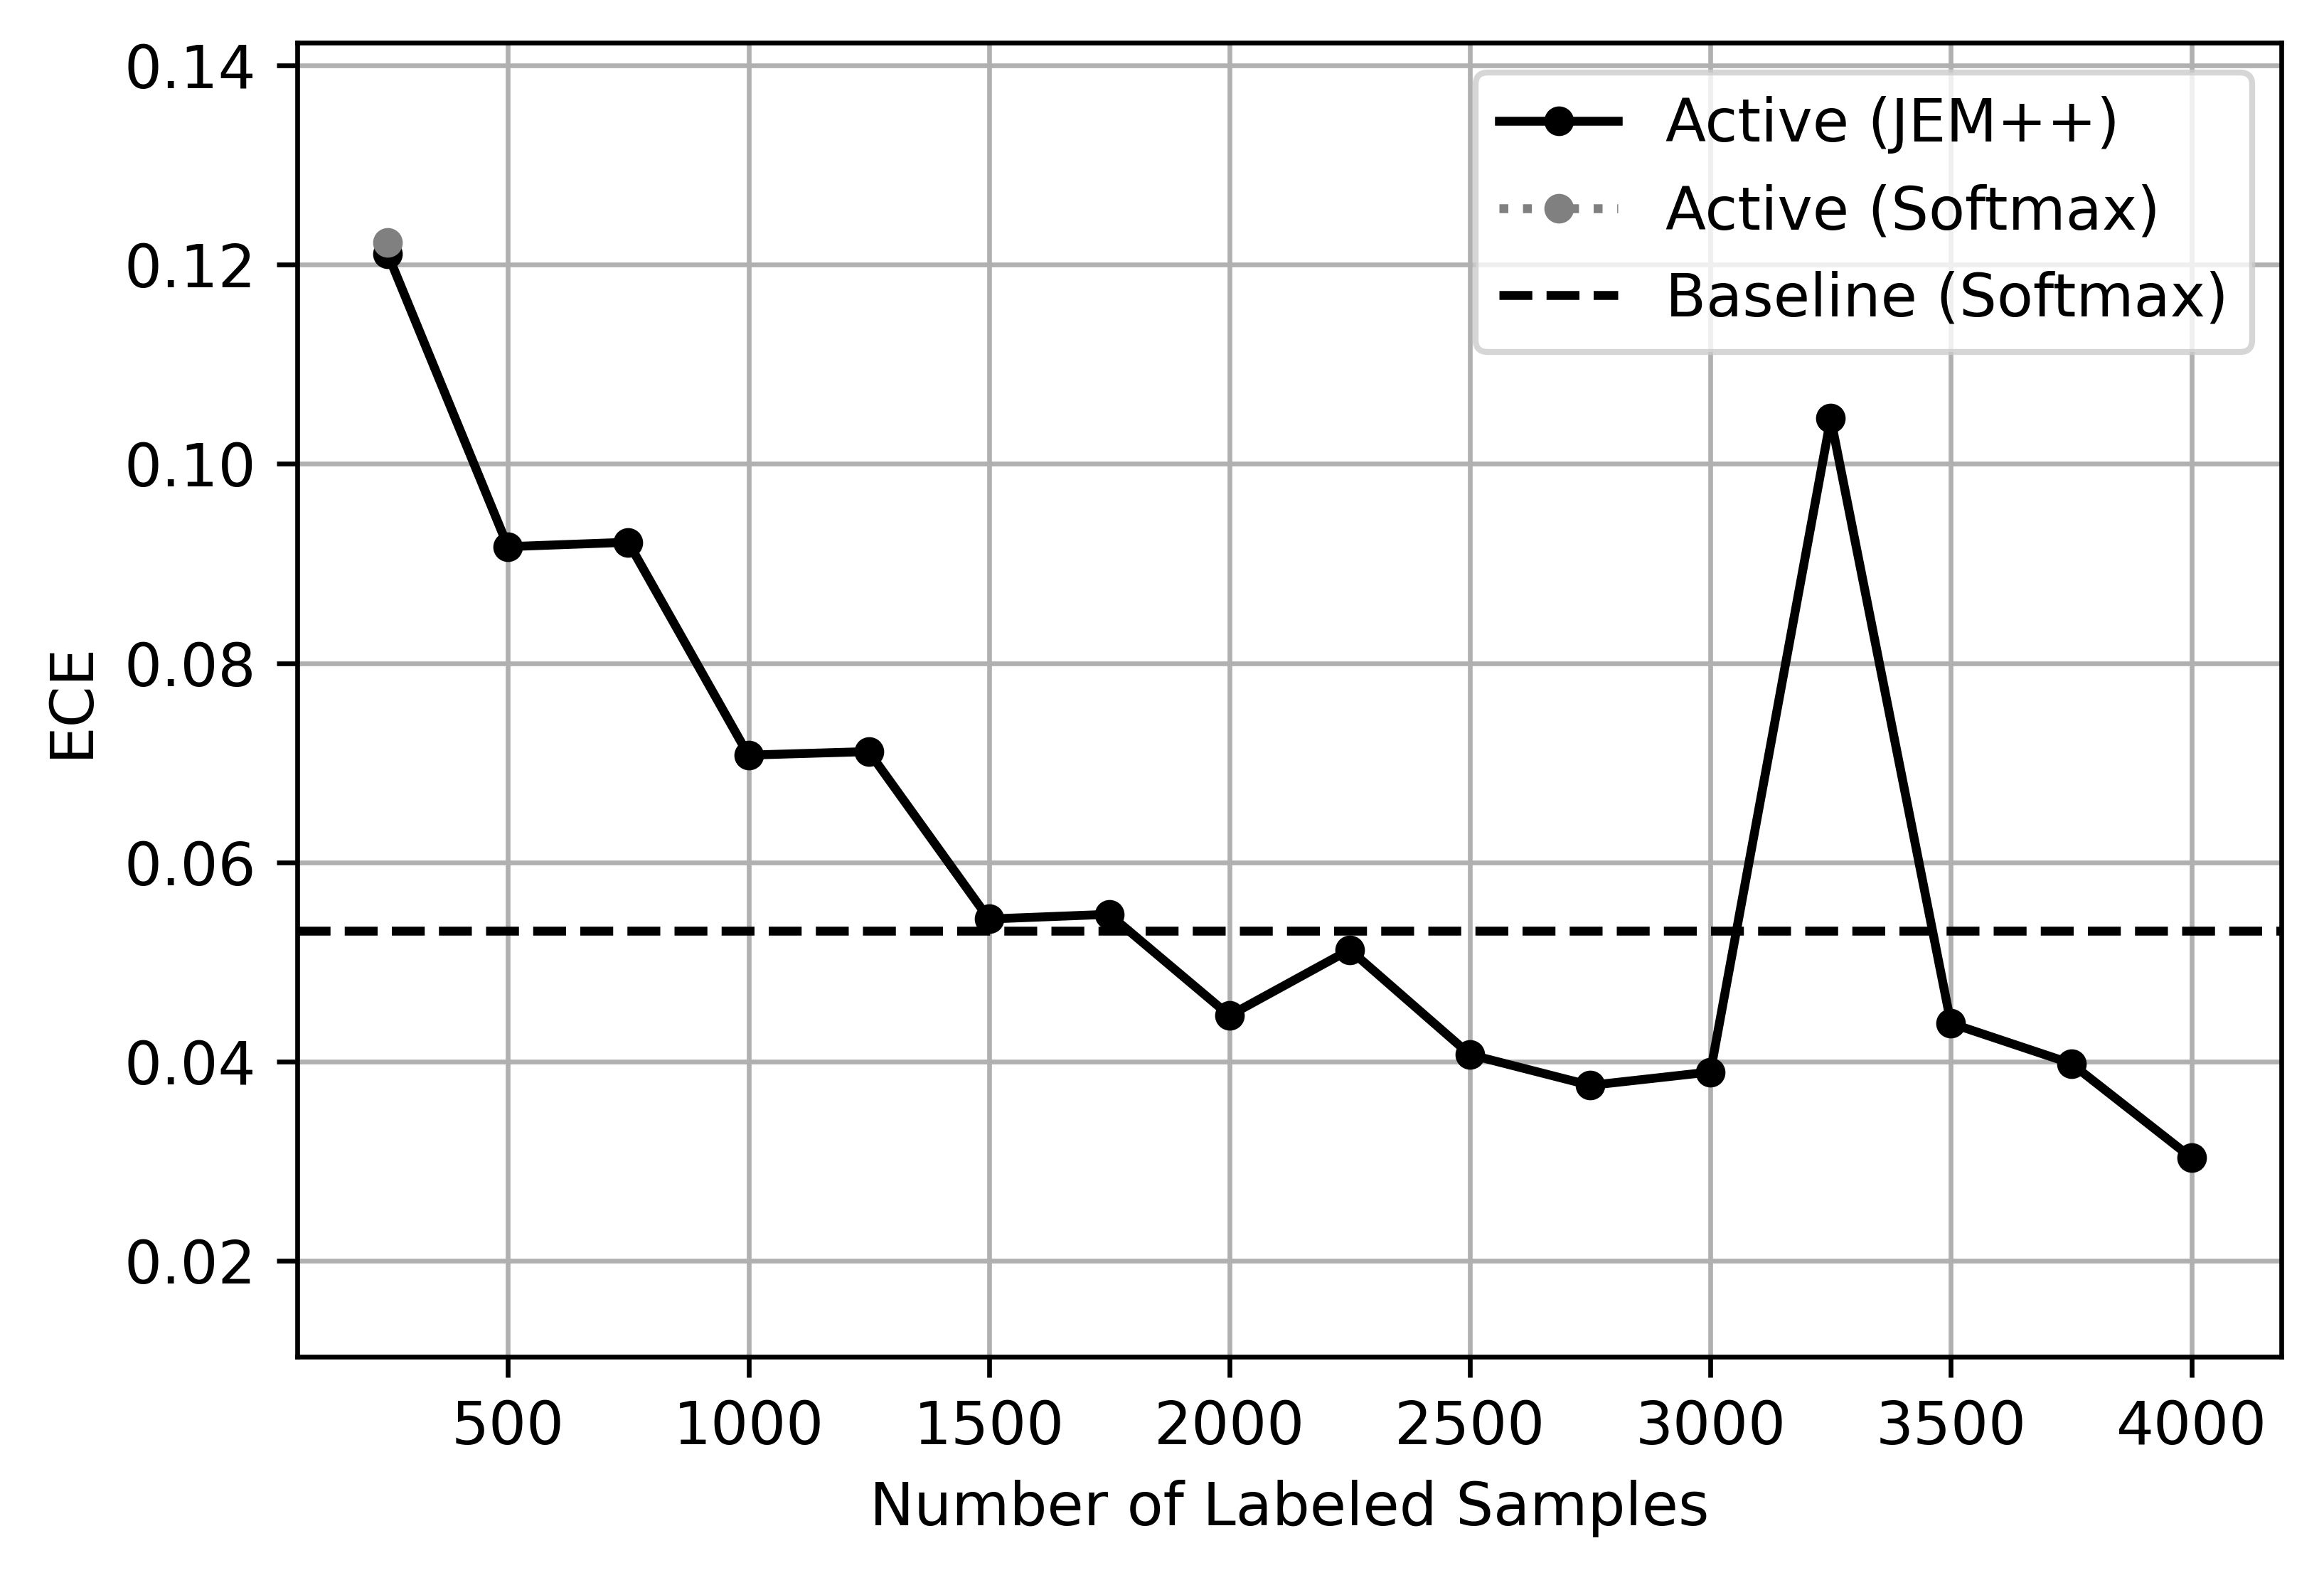

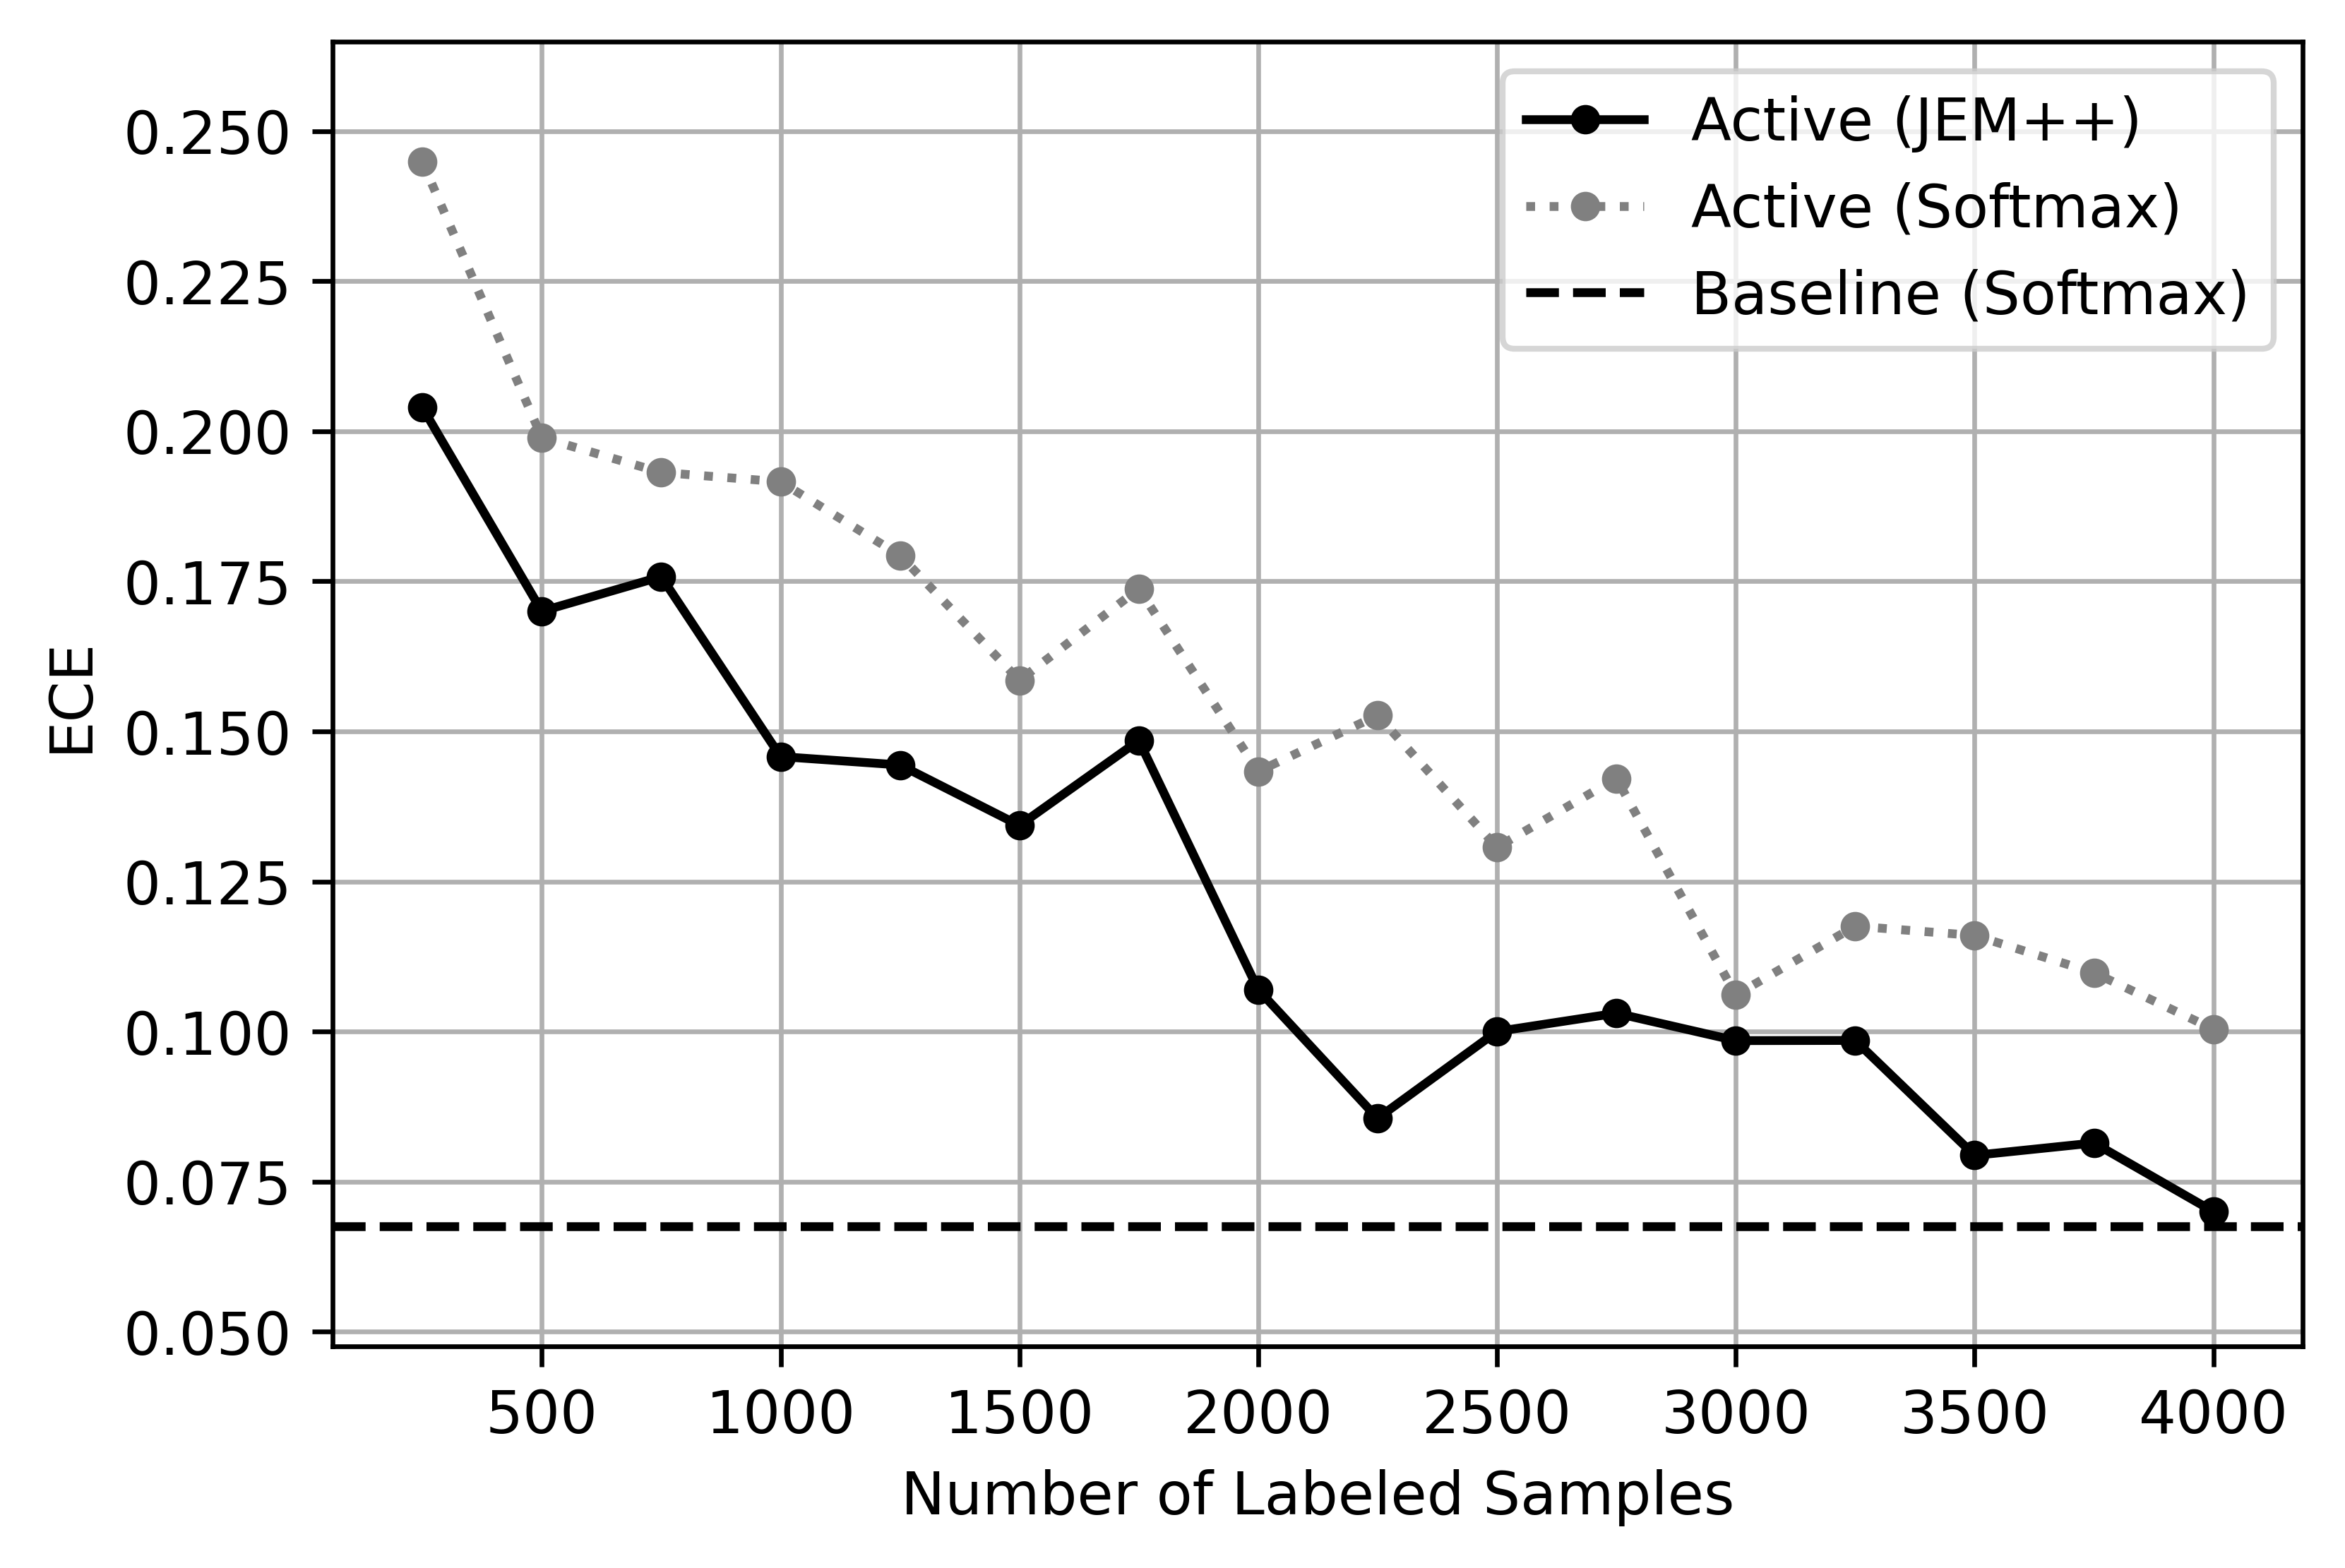

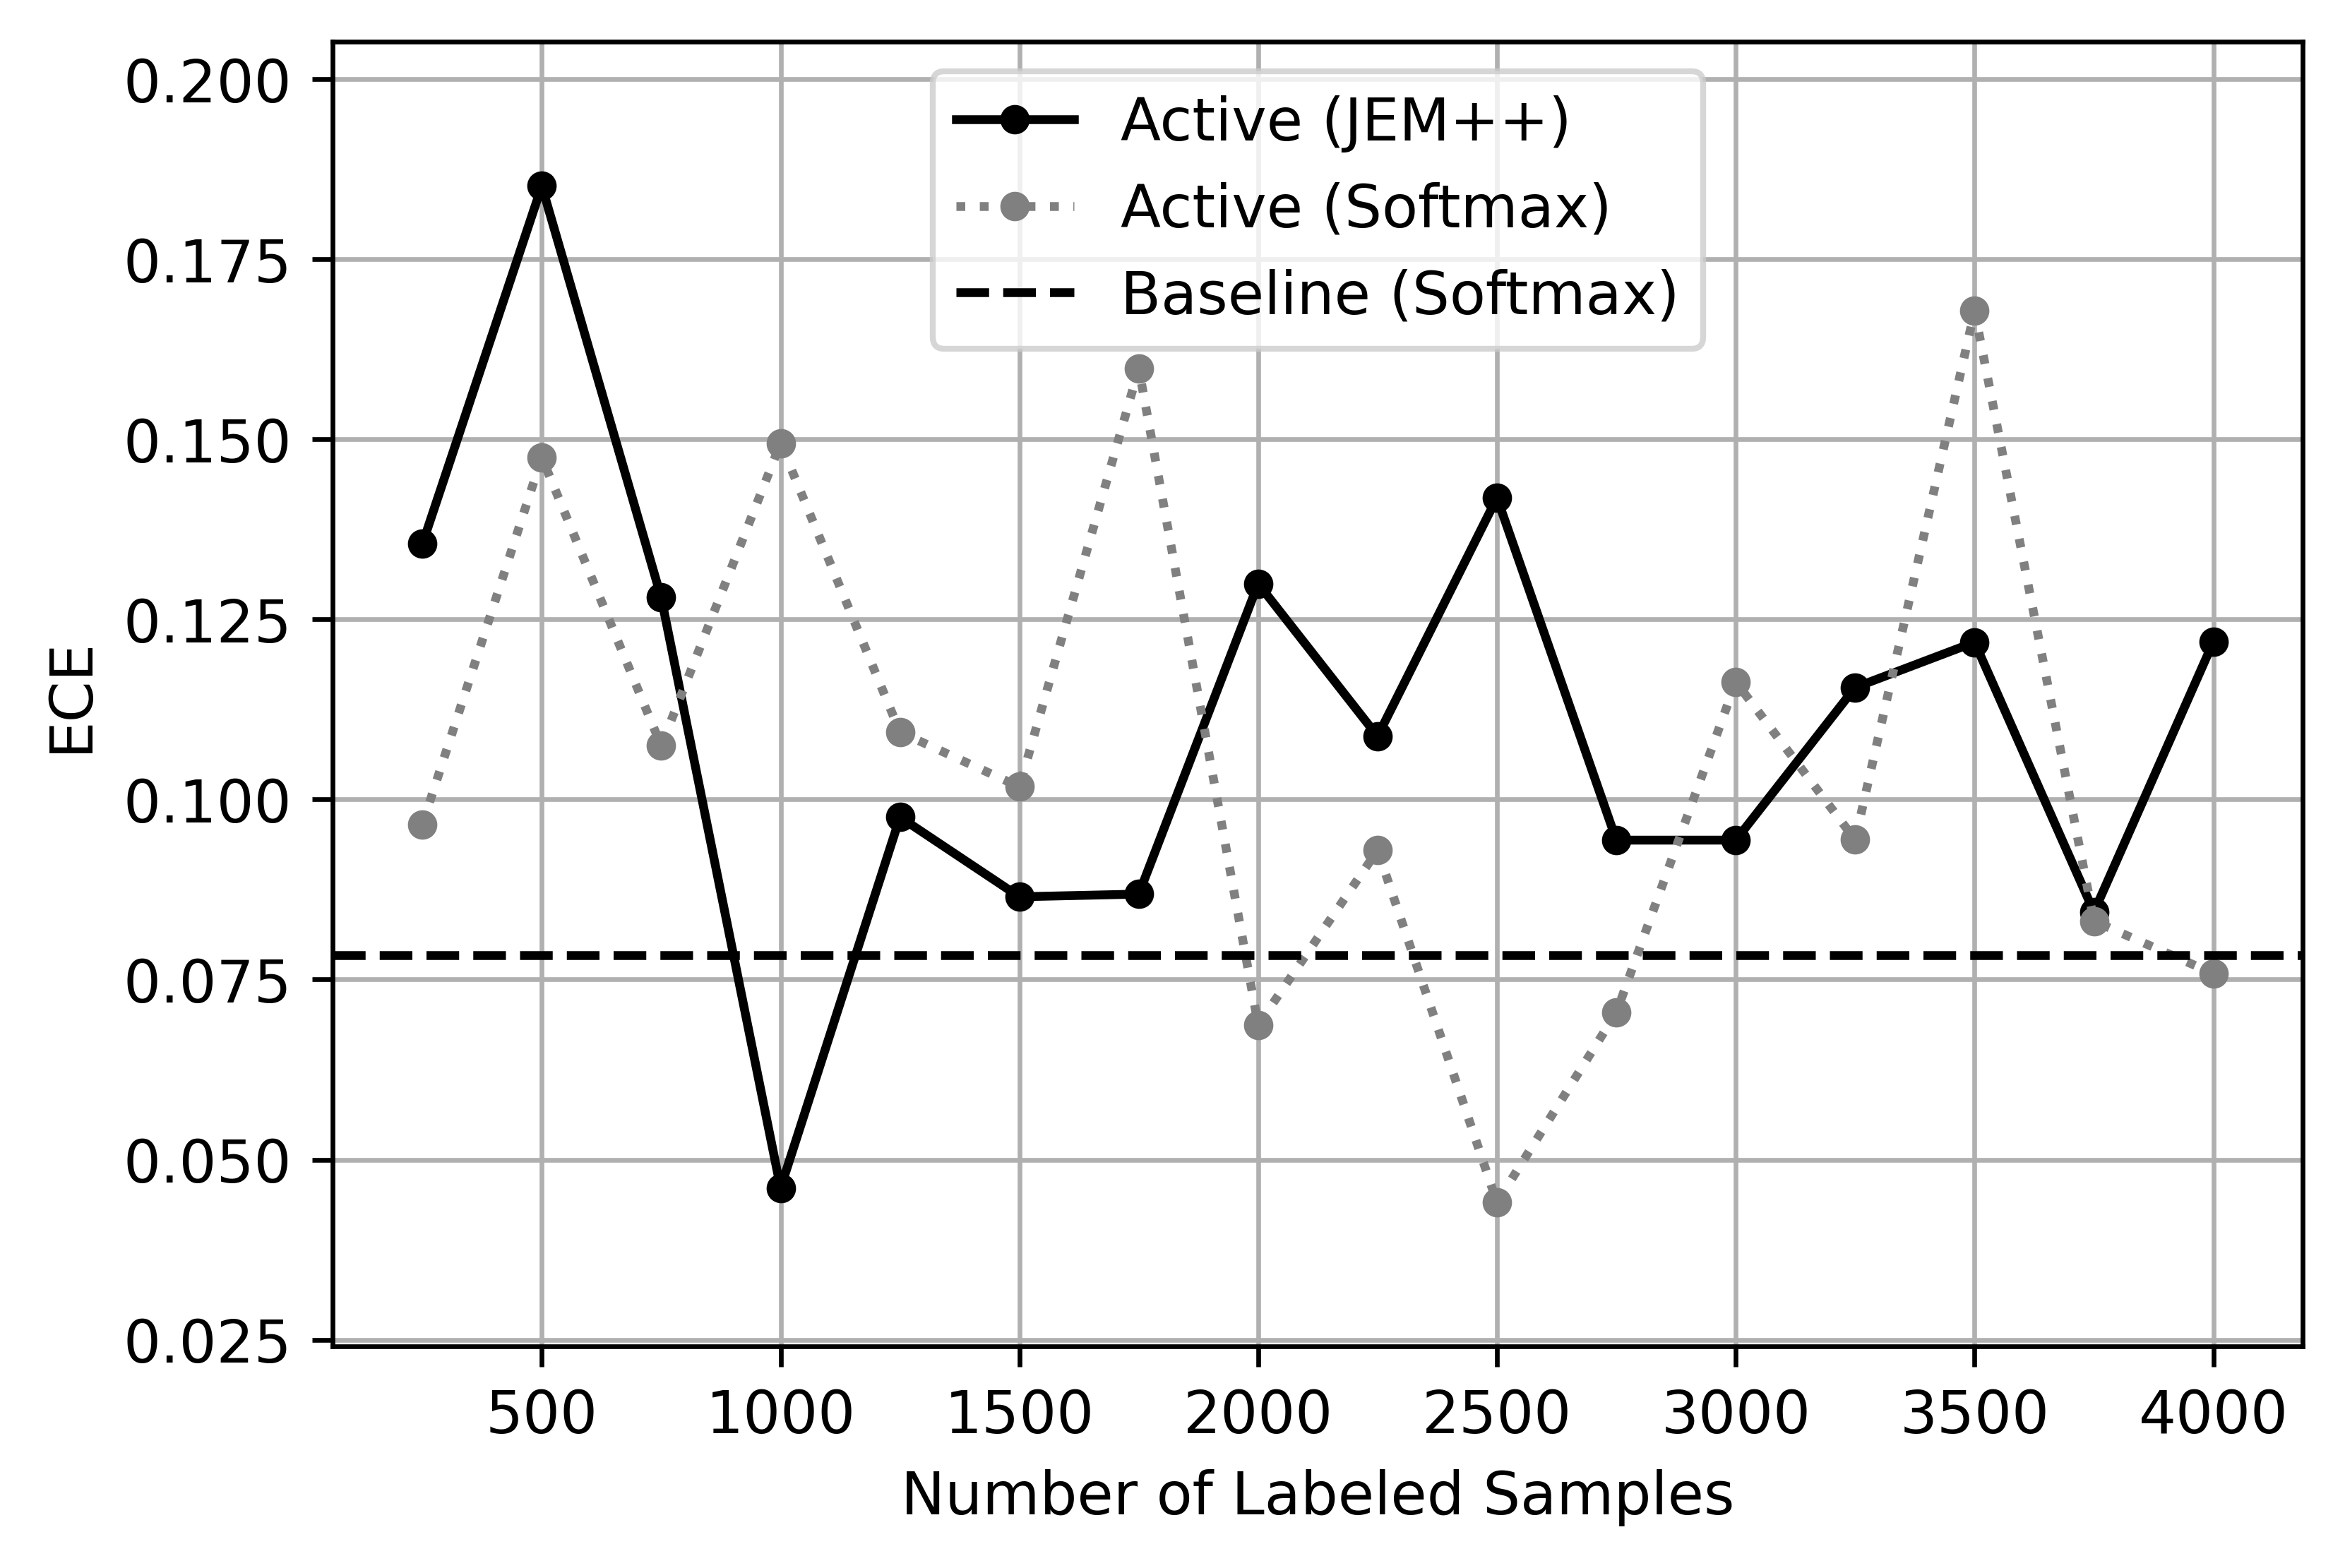

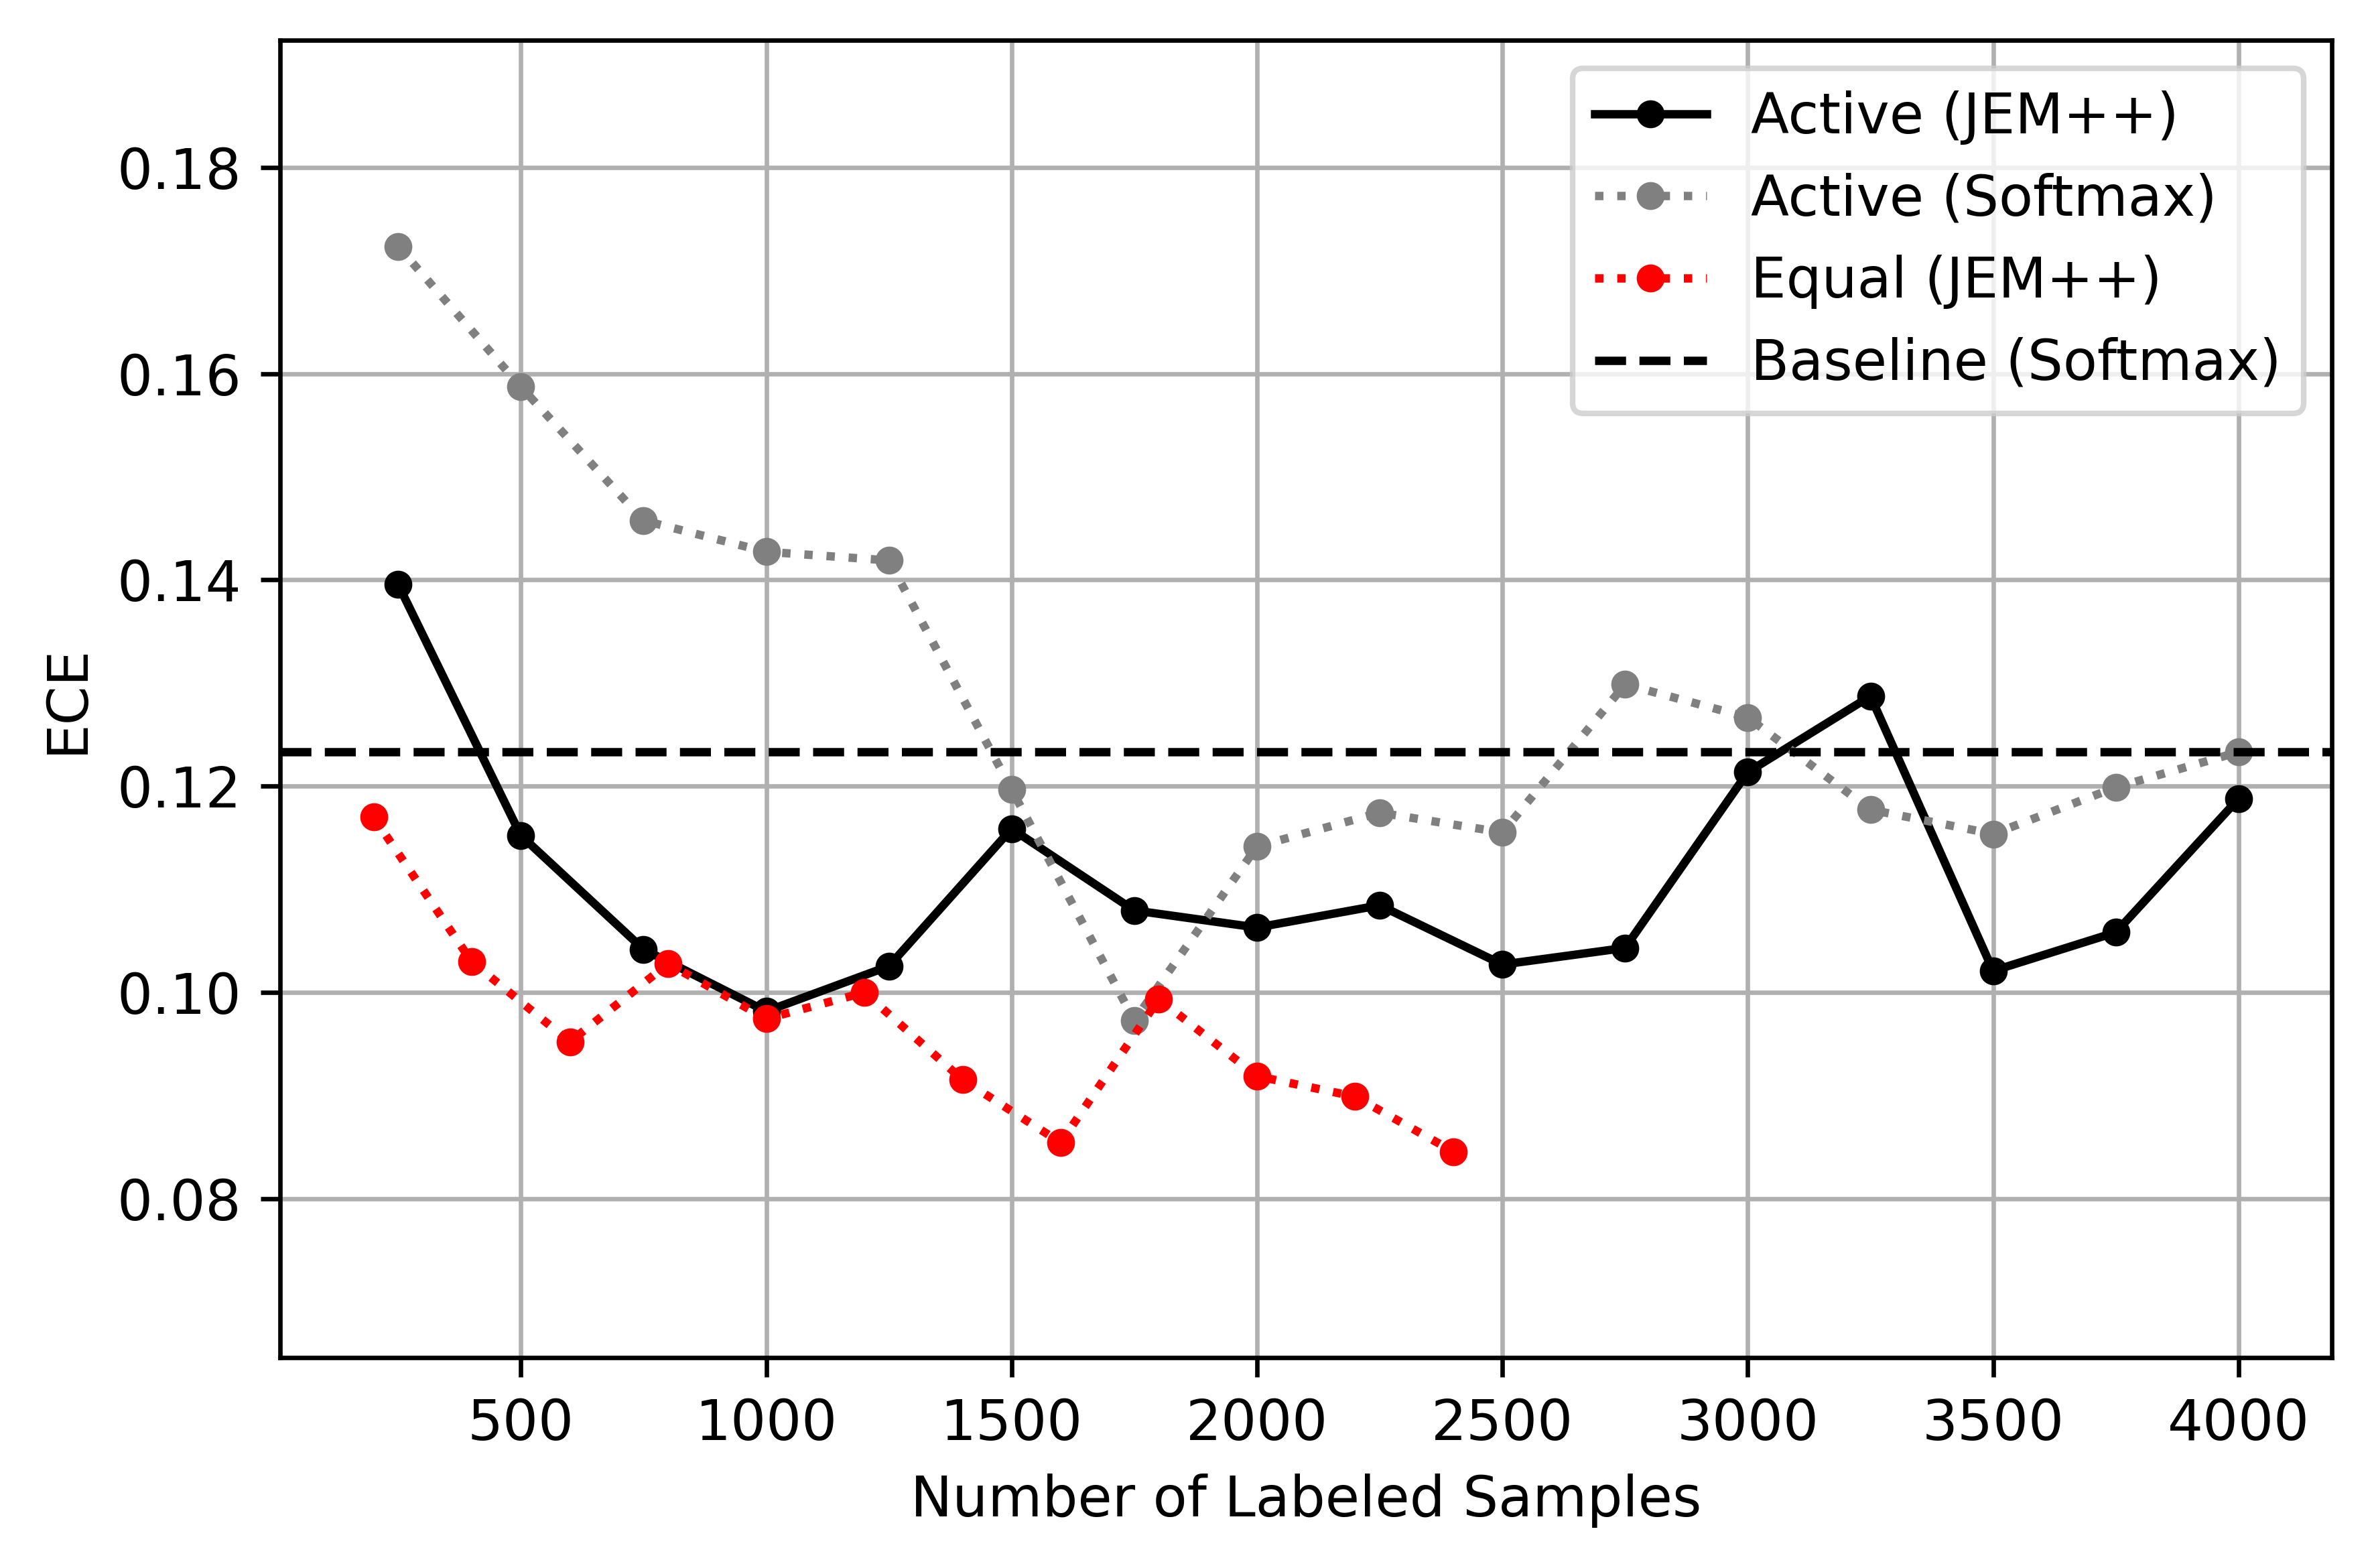

In [26]:
# Define the datasets and optimization methods
datasets = df_agg.index.get_level_values("dataset").unique()
optims = df_agg.index.get_level_values("optim").unique()

# Create a figure with 1 row and n columns
# fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=600)

# Iterate over the datasets
for i, dataset in enumerate(datasets):
    # Iterate over the optimization methods
    for j, optim in enumerate(optims):
        # Filter the data for the current dataset and optimization method
        df_filtered = df_agg.xs((dataset, optim), level=("dataset", "optim"))

        # check if df_filtered is empty, if so skip
        if df_filtered.empty:
            continue

        # print(i, j)
        fig, ax = plt.subplots(figsize=(6, 4), dpi=600)

        # ax = axs[i+j]

        # check if df_filtered as active_jempp
        if "active_jempp" in df_filtered.index.get_level_values("experiment_type"):
            # Plot the ECE mean for the active calibrated and uncalibrated methods
            df_experiment_active_jempp = df_filtered.xs("active_jempp", level="experiment_type")

            ax.plot(
                df_experiment_active_jempp.index,
                df_experiment_active_jempp[("test_ece", "mean")],
                color="black",
                marker="o",
                markersize=4,
                label="Active (JEM++)",
            )

        if "active_softmax" in df_filtered.index.get_level_values("experiment_type"):
            df_active_softmax = df_filtered.xs("active_softmax", level="experiment_type")
            ax.plot(
                df_active_softmax.index,
                df_active_softmax[("test_ece", "mean")],
                color="gray",
                marker="o",
                linestyle="dotted",
                markersize=4,
                label="Active (Softmax)",
            )

        if "equal_jempp" in df_filtered.index.get_level_values("experiment_type"):
            df_active_softmax = df_filtered.xs("equal_jempp", level="experiment_type")
            ax.plot(
                df_active_softmax.index,
                df_active_softmax[("test_ece", "mean")],
                color="red",
                marker="o",
                linestyle="dotted",
                markersize=4,
                label="Equal (JEM++)",
            )

        if "baseline_softmax" in df_filtered.index.get_level_values("experiment_type"):
            df_baseline = df_filtered.xs("baseline_softmax", level="experiment_type")
            ax.axhline(
                df_baseline[("test_ece", "mean")].values[0],
                color="black",
                linestyle="dashed",
                label="Baseline (Softmax)",
            )

        # set min and max y limits (0.2 above and below the min and max values), if min goes below 0, set to 0
        min_y = df_filtered[("test_ece", "mean")].min() - 0.02
        if min_y < 0:
            min_y = 0
        max_y = df_filtered[("test_ece", "mean")].max() + 0.02
        ax.set_ylim([min_y, max_y])

        # Set the title, labels, and legend
        # ax.set_title(f"{dataset}, {optim}")
        ax.set_xlabel("Number of Labeled Samples")
        ax.set_ylabel("ECE")
        ax.legend(loc="best")
        ax.grid()

plt.tight_layout()
plt.show()

KeyError: 'basophil'

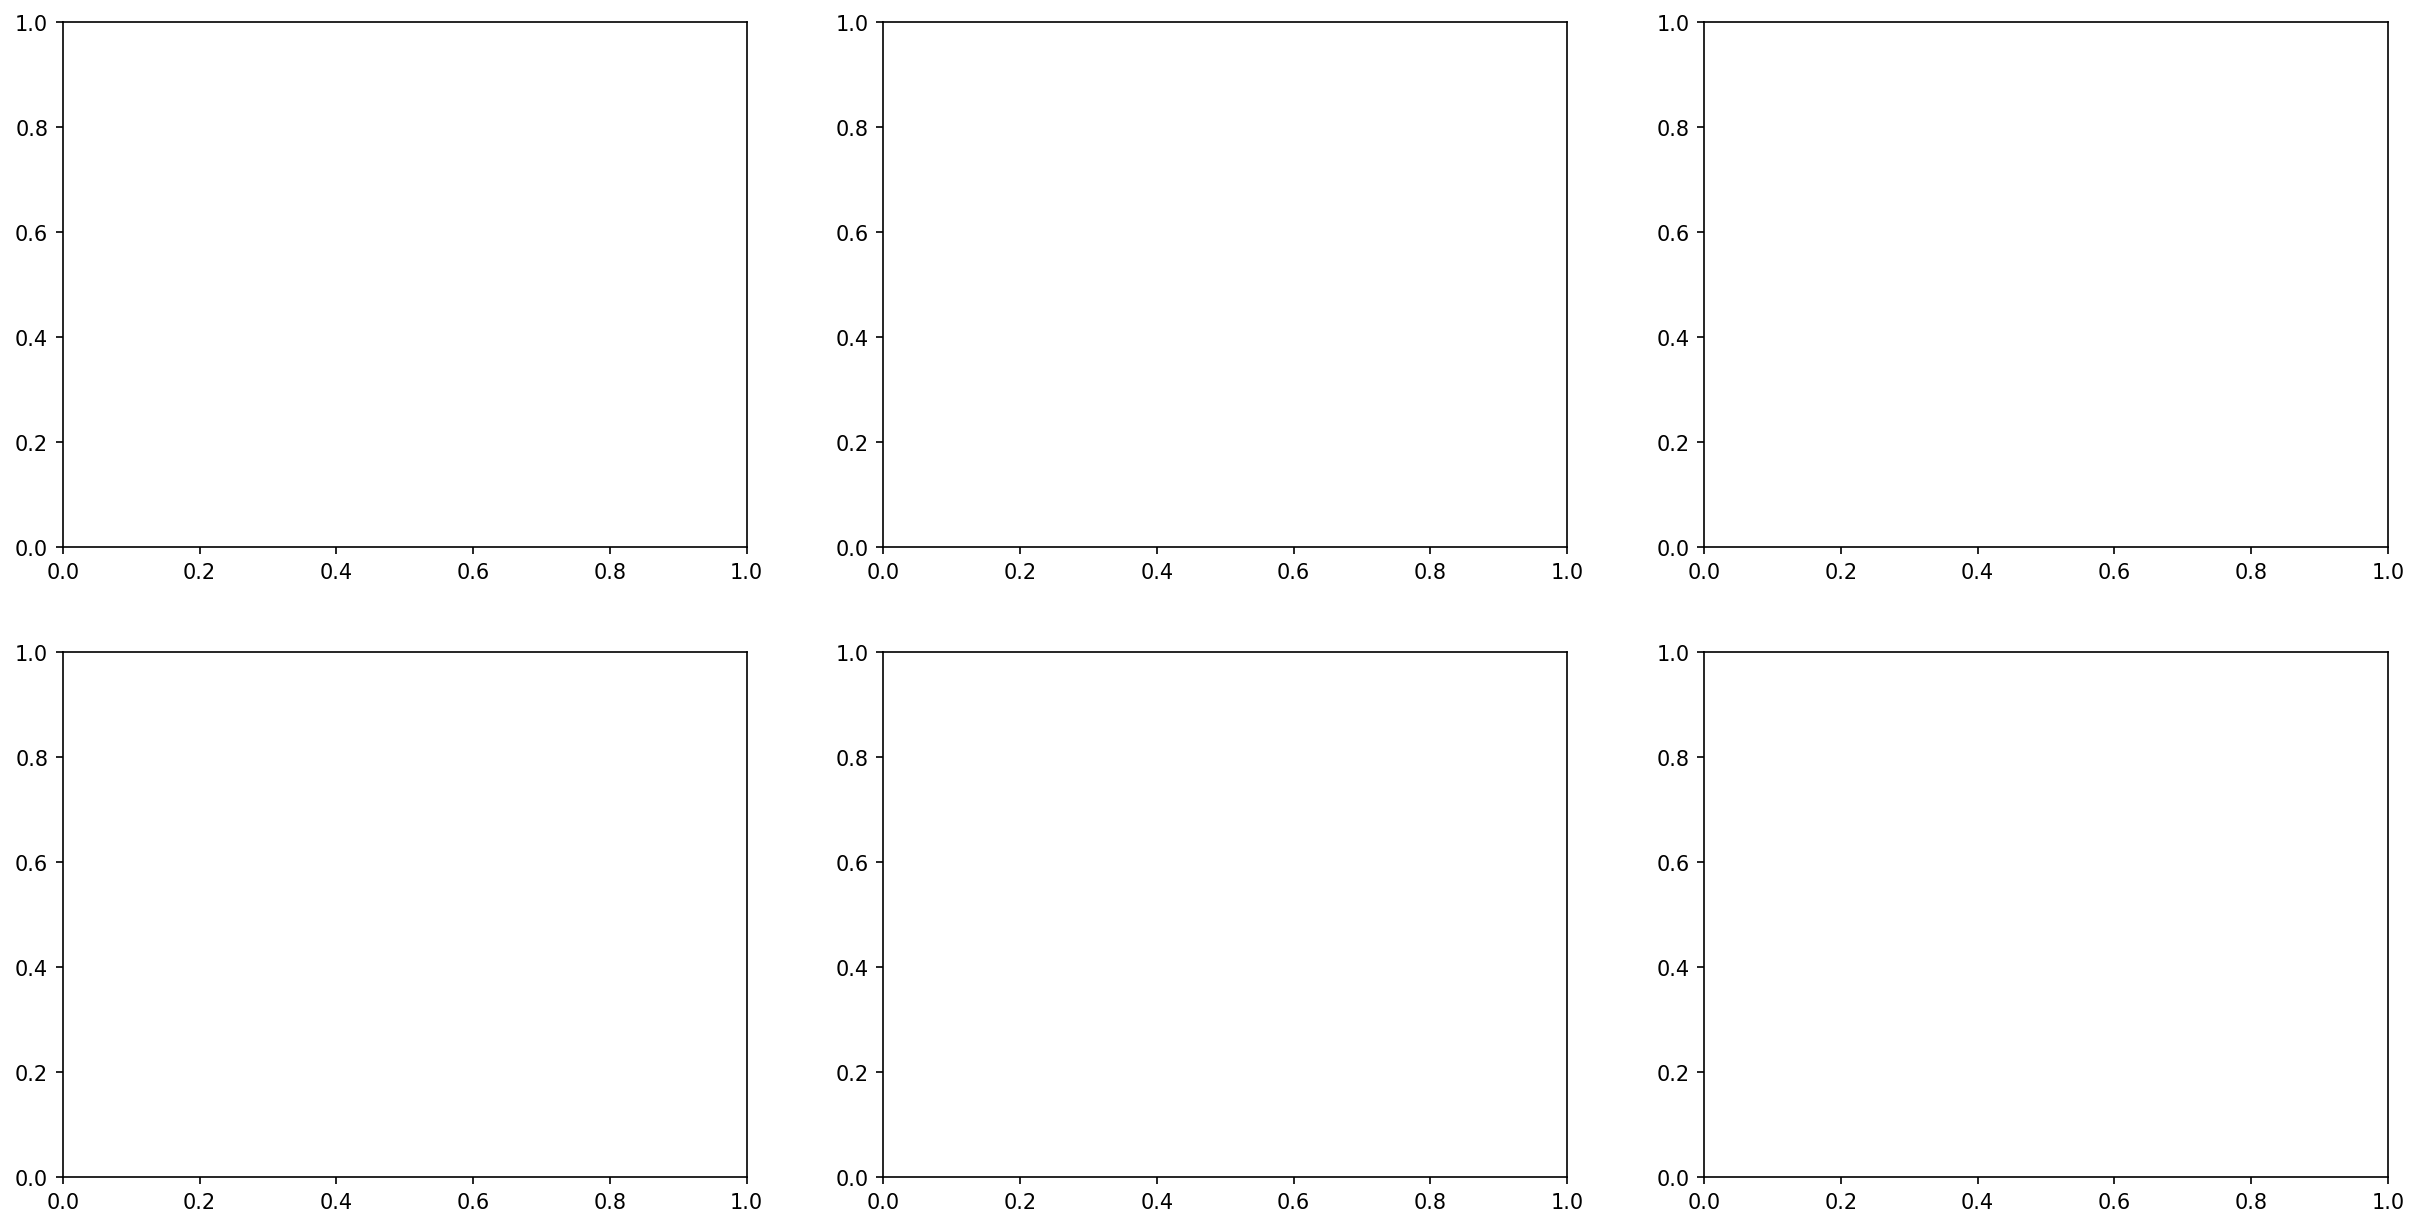

In [24]:
classes = df["acc_per_class"].values[0].keys()


# Define a function to truncate class names
def truncate_class_name(class_name, max_length=10):
    if len(class_name) > max_length:
        return class_name[:max_length] + "..."
    else:
        return class_name


# Filter for 'active_calibrated' experiment type
df_filtered = df[df["experiment_type"] == "active_jempp"]

# Get unique 'num_labeled' values and select the first, second, and last
num_labeled_values = df_filtered["num_labeled"].unique()
selected_num_labeled = [num_labeled_values[0], num_labeled_values[1], num_labeled_values[-1]]

# Filter for selected 'num_labeled' values
df_filtered = df_filtered[df_filtered["num_labeled"].isin(selected_num_labeled)]

# Group by 'num_labeled'
grouped = df_filtered.groupby("num_labeled")

fig, axs = plt.subplots(2, 3, figsize=(20, 10), dpi=150)

# Iterate over number of labeled samples
for i, (num_labeled, group) in enumerate(grouped):
    # Get the class distribution for each class
    dist_values = np.array([group["class_dist"].apply(lambda x: x[class_name]).values[0] for class_name in classes])

    full_dist_values = np.array([group["full_dist"].apply(lambda x: x[class_name]).values[0] for class_name in classes])

    classnames = [truncate_class_name(class_name) for class_name in classes]

    axs[0, i].bar(classes, full_dist_values, color="gray", zorder=1)
    axs[0, i].bar(classes, dist_values, label=f"active_calibrated {num_labeled}", color="b", zorder=2)
    axs[0, i].set_title(f"{num_labeled} labeled samples")
    axs[0, i].tick_params(axis="y", labelsize=12)
    axs[0, i].set_xticks(np.arange(len(classes)))
    axs[0, i].set_xticklabels(classnames, rotation=45, fontsize=12, rotation_mode="anchor", ha="right")
    axs[0, i].sharey(axs[0, 2])

# Iterate over number of labeled samples
for i, (num_labeled, group) in enumerate(grouped):
    # Get the class distribution for each class
    dist_values = np.array([group["acc_per_class"].apply(lambda x: x[class_name]).values[0] for class_name in classes])

    classnames = [truncate_class_name(class_name) for class_name in classes]

    # Plotting a single group of bars for each experiment type
    axs[1, i].bar(classes, dist_values, label=f"active_calibrated {num_labeled}", color="b")
    axs[1, i].set_title(f"{num_labeled} labeled samples")
    axs[1, i].tick_params(axis="y", labelsize=12)
    axs[1, i].set_xticks(np.arange(len(classes)))
    axs[1, i].set_xticklabels(classnames, rotation=45, fontsize=12, rotation_mode="anchor", ha="right")
    axs[1, i].sharey(axs[1, 2])


plt.tight_layout()
plt.show()
# plt.savefig(f"{dataset}_class_dist.png")